In [1]:
# Standard library imports
import os
import sys
import random

# Important directories
code_dir = os.path.dirname(os.getcwd())
deep_cal_dir = os.path.dirname(os.path.dirname(os.getcwd()))
# Allows to import my own module
sys.path.insert(0, code_dir)

from miscellaneous.helpers import StyblinskiTang, StyblinskiTangNN, PlotStyblinskiTang, plot_results
from miscellaneous.dataloader import SobolevDataset
from miscellaneous.models import SobolevRegressor
from miscellaneous.train_sobolev import train_sobolev

from ann.helpers import open_data

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable


random.seed(0)

In [2]:
stock_min = 80.
stock_max = 150.
rate_min = 0
rate_max = 0
vol_min = 10.
vol_max = 100.
time_min = 10.
time_max = 300.
dividend_min = 0.
dividend_max = 0.
min_ = [stock_min,rate_min,vol_min,time_min,dividend_min]
max_ = [stock_max,rate_max,vol_max,time_max,dividend_max]
sample_heston = np.random.uniform(low=min_, high=max_, size=(2000,5))/100

In [3]:
value_ = {'stock':sample_heston[:,0],'strike':1.,'rate':sample_heston[:,1],'vol':sample_heston[:,2],  'time':sample_heston[:,3], 'dividend':sample_heston[:,4]}
database = pd.DataFrame(value_)
print(database.tail())
database.to_csv('data/tmp_bs.csv',index=False)

         stock  strike  rate       vol      time  dividend
1995  1.056313     1.0   0.0  0.139453  2.408860       0.0
1996  1.063563     1.0   0.0  0.197711  1.137298       0.0
1997  1.454342     1.0   0.0  0.469785  2.081291       0.0
1998  0.999958     1.0   0.0  0.537906  0.180654       0.0
1999  1.163207     1.0   0.0  0.958191  2.896105       0.0


In [4]:
data = open_data('data/tmp_bs.csv')
data = data.to_numpy()
train_data = data[:1000]
test_data = data[1001:]

In [5]:
train_dataset =SobolevDataset(train_data)
test_dataset =SobolevDataset(test_data)

In [6]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=20,
                          shuffle=True,
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=100,
                          shuffle=True,
                          num_workers=0)

In [7]:
# black-scholes inputs
stock = torch.tensor(100.0, requires_grad=True)
strike = torch.tensor(100.0, requires_grad=True)
rate = torch.tensor(0.035, requires_grad=True)
vol = torch.tensor(0.16, requires_grad=True)
time = torch.tensor(1.0, requires_grad=True)
dividend = torch.tensor(0.01, requires_grad=True)

# utility functions
cdf = torch.distributions.Normal(0,1).cdf
pdf = lambda x: torch.distributions.Normal(0,1).log_prob(x).exp()


In [8]:
def bs(stock, strike, rate, vol, time, dividend):
    a = torch.log(stock/strike)
    b = rate - dividend
    c = vol*vol/2
    d = (vol*time**0.5)
    d1 = (a + (b + c)*time) / d
    d2 = (a + (b - c)*time) / d
    ov = strike*torch.exp(-rate*time)*cdf(-d2) - stock*torch.exp(-dividend*time)*cdf(-d1)
    return ov


In [9]:
ov = bs(stock, strike, rate, vol, time, dividend)

ov.backward()
delta = stock.grad
rho = rate.grad
vega = vol.grad
theta = time.grad
epsilon = dividend.grad
strike_greek = strike.grad


In [10]:
print(ov)
print(delta)
print(rho)
print(vega)
print(theta)
print(epsilon)
print(strike_greek)

tensor(5.0885, grad_fn=<SubBackward0>)
tensor(-0.4026)
tensor(-45.3458)
tensor(38.4103)
tensor(1.8883)
tensor(40.2573)
tensor(0.4535)


In [11]:
train_data = [[stock, strike, rate, vol, time, dividend],
              [stock, strike, rate, vol, time, dividend]]

In [12]:
train_data = torch.Tensor(train_data)
train_data = Variable(train_data, requires_grad = True)

In [13]:
ov = bs(train_data[:,0],train_data[:,1],train_data[:,2],train_data[:,3],train_data[:,4],train_data[:,5])

In [14]:
from jacobian import Jacobian
ov = ov.unsqueeze(1)
jac = Jacobian()
jac(train_data,ov)

tensor([[[ -0.4026,   0.4535, -45.3458,  38.4103,   1.8883,  40.2573],
         [ -0.4026,   0.4535, -45.3458,  38.4103,   1.8883,  40.2573]]],
       grad_fn=<CopySlices>)

In [15]:
import torch
from torch import nn, optim
import torch.nn.functional as F

_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SobolevRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6, 256)

        self.fc2 = nn.Linear(256, 256)

        self.fc3 = nn.Linear(256, 256)

        self.fc4 = nn.Linear(256,1)
    
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))

        x = self.fc4(x)
        
        return x
    
model = SobolevRegressor()

In [16]:
import os
import sys

code_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, code_dir)

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import pandas as pd

from torch import nn, optim
import torch
from torch.autograd import Variable, grad
from torch.utils.tensorboard import SummaryWriter

import numpy as np

from ann.model import init_weights
from miscellaneous.jacobian import Jacobian
from miscellaneous.helpers import StyblinskiTangNN

_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(code_dir + '/ann/runs/lifted_heston_experiment')

f1 = bs


def train_sobolev(model,
                  train_loader,
                  test_loader,
                  lambd,
                  nb_epochs,
                  seed, 
                  save_model_dir,
                  log_df= 'log_df.csv'):
    """
    Arguments:

        train_loader:   Dataloader. 
            train_loader.features: array-like, shape=[# samples, # features].
                Features of the data set.
            train_loader.labels: array-like, shape=[# samples, # labels].
                Labels of the data set.
        test_loader:   Dataloader.
            test_loader.features: array-like, shape=[# samples, # features].
                Features of the data set.
            test_loader.labels: array-like, shape=[# samples, # labels].
                Labels of the data set.
        lambd: double.
            Proportion for the sobolev mean squared error.
        nb_epochs: integer.
            Number of epochs to train the network.
        seed: integer.
            Random seed for PRNG, allowing reproducibility of results.
        project_dir: string.
            Project directory to write to.
        log_df: pandas dataframe, shape=[, nb_layers + 8], default = None
            Pandas df that serves as a log file. If none, df is created.
    Returns:
        log_df: pandas dataframe.
            Pandas df log file with training and validation metrics across eps.
        best_error: float
            Best error on test set among epochs.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(),lr=0.0005)

    train_loss_min = np.Inf
    steps = 0
    model.apply(init_weights)
    model.to(_device)
    jacobian = Jacobian()
    train_losses,train_L1losses,train_L2losses, test_losses,test_L1losses, learningRate = [], [], [], [],[],[]

    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
    
    epochs_iter = tqdm_notebook(range(nb_epochs), desc="Epoch")
    for e in epochs_iter:
        running_loss = 0
        L1Loss = 0
        L2Loss = 0
        for features in train_loader:
            
            features = features.type(torch.FloatTensor)
            features = features.to(_device)

            features = Variable(features,requires_grad = True)
            #print(features)
            labels = f1(features[:,0],features[:,1],features[:,2],features[:,3],features[:,4],features[:,5])
            labels = labels.unsqueeze(1)


            MSE = model(features)
            #print(labels)
            
            #MSE.requires_grad = True

            #labels = Variable(labels,requires_grad=True)

            J_teacher = jacobian(features, labels)
            J_student = jacobian(features, MSE)
            #print(J_teacher)
            loss = criterion(MSE, labels) 

            loss_sobolev = criterion(J_teacher.flatten(), J_student.flatten())

            loss_total =  loss + lambd * loss_sobolev

            optimizer.zero_grad() # dé-commenter si on utilise pas Adatune
            loss_total.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 2000)

            optimizer.step()
 
            L1Loss += loss.item()
            L2Loss += loss_sobolev.item()
            running_loss += loss_total.item()

        else:
            test_L1loss = 0
            test_L2loss = 0
            test_loss = 0
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                model.eval()
                for features1 in test_loader:
                    
                    
                    features1 = features1.type(torch.FloatTensor)

                    #features1= features1.to(_device)  #,dlabels1.to(_device)
                    labels1 = f1(features1[:,0],features1[:,1],features1[:,2],features1[:,3],features1[:,4],features1[:,5])
                    MSE = model(features1)
                    labels1 = labels1.unsqueeze(1)
                    test_L1loss += criterion(MSE, labels1)
                    
                    test_loss += test_L1loss 

                    
                    
                    
            model.train()        
            train_losses.append(running_loss/len(train_loader))
            train_L1losses.append(L1Loss/len(train_loader))
            train_L2losses.append(L2Loss/len(train_loader))

            test_loss = test_loss/len(test_loader)
            test_losses.append(test_loss)
            test_L1losses.append(test_L1loss/len(test_loader))


            learningRate.append(optimizer.param_groups[0]['lr'])
            #scheduler.step(test_loss)

            """print(
                  "Training Loss: {:.7f}.. ".format(L1Loss/len(train_loader)),
                  "Training Sobolev Loss: {:.7f}..".format(L2Loss/len(train_loader)),
                  "Training Full Loss: {:.7f}..".format(running_loss/len(train_loader)),
                  "Test Loss: {:.3f}.. ".format(np.sqrt(test_loss)))"""
            # save model if validation loss has decreased
            if running_loss <= train_loss_min:
                #print('Validation loss decreased ({} --> {}).  Saving model ...'.format(train_loss_min,running_loss))
                #torch.save(model.state_dict(),save_model_dir)
                train_loss_min = running_loss
            
    #learning_data = pd.DataFrame(list(zip(train_losses,train_L1losses, train_L2losses, test_losses, test_L1losses, learningRate)),columns=['Train Losses', 'Train L1 Losses', 'Train L2 Losses','Test Losses','Test L1 Losses', 'Learning Rate'])
    #learning_data.to_csv(log_df,index=False)
    
    return train_L1losses, train_L2losses, test_losses

In [17]:
tr1, tr2, tes = train_sobolev(model,train_loader,test_loader,1,1000,0, 'results/heston_tmp.pt',log_df= 'log_df.csv')

In [38]:
test_result = pd.DataFrame(tes,columns=['value'])
test_result.sort_values(by='value')

,value
975,0.000007
677,0.000007
864,0.000007
859,0.000008
682,0.000008
...,...
23,0.011269
0,0.014536
12,0.015195
88,0.023520


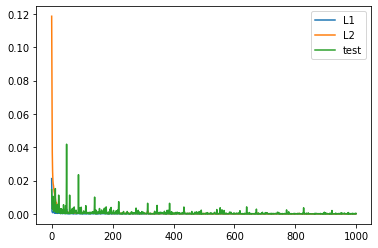

In [19]:
from matplotlib import pyplot as plt
plt.plot(tr1,label='L1')
plt.plot(tr2,label='L2')
plt.plot(tes,label='test')
#plt.yscale('log')
plt.legend()


In [20]:
val = []
for i in [0.3,0.4,0.6,0.8,0.9,0.95,0.975,1.,1.025,1.05,1.1,1.2,1.3,1.5,1.75,2,2.5,3]:
    pred = torch.tensor([i,1,0, 0.1, 0.5, 0])
    orig = bs(torch.tensor(i),torch.tensor(1.),torch.tensor(0.), torch.tensor(0.1), torch.tensor(0.5), torch.tensor(0.))
    if model(pred) < 0.:
        val.append([0.,orig])
    else:
        val.append([model(pred),orig])

In [21]:
val


[[tensor([0.8762], grad_fn=<AddBackward0>), tensor(0.7000)],
 [tensor([0.7312], grad_fn=<AddBackward0>), tensor(0.6000)],
 [tensor([0.4476], grad_fn=<AddBackward0>), tensor(0.4000)],
 [tensor([0.2015], grad_fn=<AddBackward0>), tensor(0.2000)],
 [tensor([0.1009], grad_fn=<AddBackward0>), tensor(0.1020)],
 [tensor([0.0597], grad_fn=<AddBackward0>), tensor(0.0594)],
 [tensor([0.0430], grad_fn=<AddBackward0>), tensor(0.0421)],
 [tensor([0.0294], grad_fn=<AddBackward0>), tensor(0.0282)],
 [tensor([0.0188], grad_fn=<AddBackward0>), tensor(0.0178)],
 [tensor([0.0112], grad_fn=<AddBackward0>), tensor(0.0105)],
 [tensor([0.0030], grad_fn=<AddBackward0>), tensor(0.0030)],
 [tensor([0.0010], grad_fn=<AddBackward0>), tensor(0.0001)],
 [tensor([0.0022], grad_fn=<AddBackward0>), tensor(1.9848e-06)],
 [tensor([0.0068], grad_fn=<AddBackward0>), tensor(0.)],
 [tensor([0.0150], grad_fn=<AddBackward0>), tensor(0.)],
 [tensor([0.0234], grad_fn=<AddBackward0>), tensor(0.)],
 [tensor([0.0408], grad_fn=<AddB

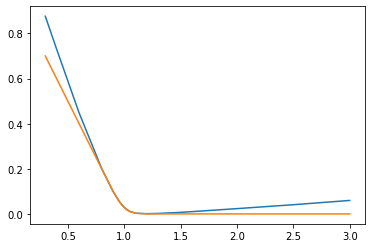

In [22]:
val = np.array(val,dtype=np.float64)
time = [0.3,0.4,0.6,0.8,0.9,0.95,0.975,1.,1.025,1.05,1.1,1.2,1.3,1.5,1.75,2,2.5,3]
plt.plot(time,val)

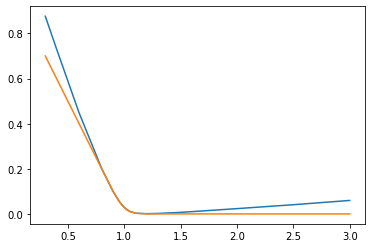

In [23]:
val = np.array(val,dtype=np.float64)
time = [0.3,0.4,0.6,0.8,0.9,0.95,0.975,1.,1.025,1.05,1.1,1.2,1.3,1.5,1.75,2,2.5,3]
plt.plot(time,val)

In [24]:
from pricing.newton_iv import newton_raphson
from pricing.linear_iv import linear

In [25]:
val = np.array(val,dtype=np.float64)
res = []
for i in range(len(val)) :
    res.append(newton_raphson(1.,time[i],0.0,0.8,linear(1,time[i],0.0,0.8,val[i,0]) ,val[i,0], 1)) #i,1,0, 0.1, 0.8, 0

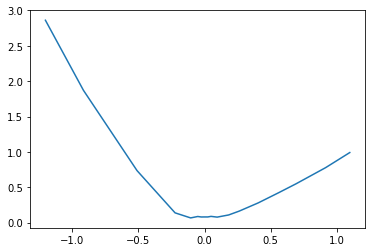

In [26]:
plt.plot(np.log(time),res)
